In [60]:
from docplex.mp.model import Model
import numpy as np
from plot import plot_tsp
from scipy.spatial.distance import cdist
from docplex.mp.relax_linear import LinearRelaxer

In [61]:
num_cities = 50

V = list(range(num_cities))
E = [(i, j) for i in V for j in V if i != j]

X = np.random.default_rng(0).random((len(V), 2))

# compute euclidean distance matrix
c = cdist(X, X)
c.shape

(50, 50)

In [62]:
model = Model('TSP_MTZ')

x = model.binary_var_dict(E, name='x')
u = model.integer_var_dict(V[1:], name='u')

# add in and out degree constraints
model.add_constraints(model.sum(x[i, j] for i in V if i != j) == 1 for j in V)
model.add_constraints(model.sum(x[i, j] for j in V if i != j) == 1 for i in V)

# add lazy subtour elimination constraints
model.add_constraints(u[i] - u[j] + (len(V) - 1) * x[i, j] <= len(V) - 2
                      for i in V[1:] for j in V[1:] if i != j)

# objective function
model.minimize(model.sum(c[i, j] * x[i, j] for i in V for j in V if i != j))

lp = LinearRelaxer.make_relaxed_model(model)
lp.print_information()
    
solution = lp.solve(log_output=False)

Model: lp_TSP_MTZ
 - number of variables: 2499
   - binary=0, integer=0, continuous=2499
 - number of constraints: 2452
   - linear=2452
 - parameters: defaults
 - objective: minimize
 - problem type is: LP


Tour cost: 4.364866251491819
10 -> 1 = 1.0
22 -> 36 = 1.0


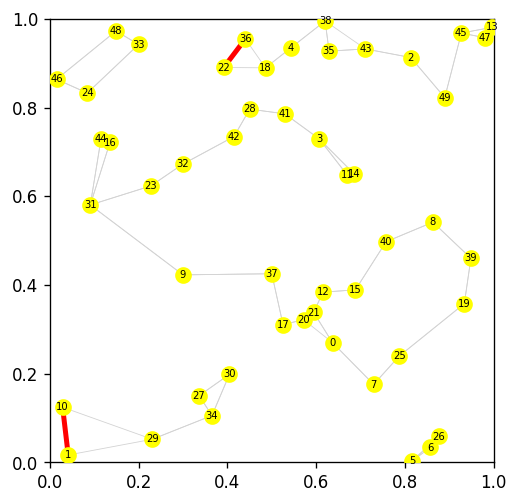

In [64]:
sol_edges = dict()
for i, x_i in x.items():
    v = solution[x_i.name]
    if v > 0:
        sol_edges[i] = v

print(f'Tour cost: {solution.objective_value}')


import matplotlib.pyplot as plt

plt.figure(dpi=120)

for i in range(X.shape[0]):
    plt.text(X[i, 0], X[i, 1], i, ha='center', va='center', fontsize=6, color='black', zorder=30)
    plt.scatter(X[i, 0], X[i, 1], c='yellow', linewidths=4, zorder=10)    

for (i, j), v in sol_edges.items():        
    if v == 1:
        print(f'{i} -> {j} = {v}')
    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], color=('red' if v == 1 else 'lightgrey'), zorder=(9 if v == 1 else 5), linewidth=(3 if v == 1 else 0.5))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')